In [1]:
import os
import py7zr
import time 
import spacy
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

#import tensorflow as tf
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras.models import Sequential
#from keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, Embedding

from xgboost import XGBClassifier
from gensim.models import KeyedVectors
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

#from cuml.svm import SVC as cumlSVC
#from cuml.linear_model import LogisticRegression as cuLogisticRegression
#from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier

2025-03-13 21:59:10.265529: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 21:59:10.277180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741899550.294736   10981 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741899550.299640   10981 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1741899550.313746   10981 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Input data

## [experimentation data] - PubMed 20k RCT dataset  

### [for EXPERIMENTATION part]

In [2]:
data_dir = "./pubmed-rct/PubMed_20k_RCT"

## [deployment data] - PubMed 200k RCT dataset

### [for DEPLOYMENT part]

In [3]:
data_dir = "./pubmed-rct/PubMed_200k_RCT"

In [4]:
val_path = os.path.join(data_dir, "dev.txt")
test_path = os.path.join(data_dir, "test.txt")
train_path = os.path.join(data_dir, "train.txt")
train_extracted_path = os.path.join(data_dir, "train.txt")
#nlp = spacy.load("en_core_sci_sm")

# Extract ".7z" zip file, if not done yet
if not os.path.exists(train_extracted_path):
    with py7zr.SevenZipFile("./pubmed-rct/PubMed_200k_RCT/train.7z", mode='r') as archive:
        archive.extractall(data_dir)

## Load data

In [5]:
def load_dataset(file_path):
    sentences = []
    labels = []
    with open(file_path, "r") as file:
        for line in file:
            line = line.strip()
            if line.startswith("###") or line == "":
                continue  # to skip document IDs and empty lines
            else:
                label, text = line.split("\t")
                sentences.append(text)
                labels.append(label)
    return sentences, labels

## Train/Test/Val Split

In [6]:
train_sentences, train_labels = load_dataset(train_extracted_path)
val_sentences,   val_labels   = load_dataset(val_path)     
test_sentences,  test_labels  = load_dataset(test_path)

## Dataset overview

In [7]:
label_counts = Counter()

with open(train_path, "r") as file:
    for line in file:
        line = line.strip()
        if line and not line.startswith("###"):  # Ignore document IDs
            label, _ = line.split("\t", 1)  
            label_counts[label] += 1 

# Number of sentences assigned to each label in the dataset
print("Annotation Distribution (Sentence Counts per Label) :")
print(f"{'-'*40}")
for label, count in label_counts.most_common():
    print(f"{label:<15} {count}")

Annotation Distribution (Sentence Counts per Label) :
----------------------------------------
RESULTS         766271
METHODS         722586
CONCLUSIONS     339714
BACKGROUND      196689
OBJECTIVE       186601


In [8]:
all_sentences = train_sentences + val_sentences + test_sentences
vocabulary = set(word for sentence in all_sentences for word in sentence.split())

print(f"Vocabulary Size: {len(vocabulary)} unique words")

Vocabulary Size: 479444 unique words


In [9]:
print(f"{'Dataset':<20}{'Sentences':<13}{'Labels':<9}")
print(f"{'-'*40}")
print(f"{'Training Data:':<20}{len(train_sentences):<13}{len(train_labels):<10}")
print(f"{'Validation Data:':<20}{len(val_sentences):<13}{len(val_labels):<10}")
print(f"{'Test Data:':<20}{len(test_sentences):<13}{len(test_labels):<10}")

Dataset             Sentences    Labels   
----------------------------------------
Training Data:      2211861      2211861   
Validation Data:    28932        28932     
Test Data:          29493        29493     


# [EXPERIMENTATION]

## Fine-tuning strategy

In [13]:
def optimize_hyperparameters(vectorizer, model, param_grid, train_sentences, train_labels, val_sentences, val_labels, classifier_name):
    X_train = vectorizer.fit_transform(train_sentences) if vectorizer else train_sentences
    
    grid_search = GridSearchCV(estimator=model, 
                               param_grid=param_grid, 
                               cv=3, 
                               scoring='accuracy', 
                               n_jobs=-1, 
                               return_train_score=True)
    grid_search.fit(X_train, train_labels)

    results = grid_search.cv_results_
    param_names = list(param_grid.keys())

    # Visualize results (only works if 1 hyperparameter was tuned)
    if len(param_names) == 1:
        param_values = param_grid[param_names[0]]
        
        mean_train_scores = results['mean_train_score']
        std_train_scores = results['std_train_score']
        mean_test_scores = results['mean_test_score']
        std_test_scores = results['std_test_score']

        plt.figure(figsize=(10, 6))
        plt.errorbar(param_values, mean_train_scores, yerr=std_train_scores, label="train score", marker='o')
        plt.errorbar(param_values, mean_test_scores, yerr=std_test_scores, label="valid score", marker='o')
        plt.xlabel(param_names[0])
        plt.ylabel("scores")
        plt.xscale('log')  # logarithmic scale for the x-axis
        plt.title(f"Hyperparameter Optimization for {classifier_name}")
        plt.grid(True)
        plt.legend()
        plt.show()

    # Return the best estimator
    best_model = grid_search.best_estimator_
    print(f"Best hyperparameters for {classifier_name}: {grid_search.best_params_}")
    return best_model

## 1. Baseline model: Bag-of-Words 

In [14]:
def baseline_optimized_model(vectorizer, model, param_grid, train_sentences, train_labels, val_sentences, 
                             val_labels, test_sentences, test_labels, classifier_name):
    # Optimize hyperparameters
    best_model = optimize_hyperparameters(vectorizer, 
                                          model, 
                                          param_grid, 
                                          train_sentences, train_labels, val_sentences, val_labels, 
                                          classifier_name)

    # Vectorize input sentences
    X_train = vectorizer.fit_transform(train_sentences) if vectorizer else train_sentences
    X_test = vectorizer.transform(test_sentences) if vectorizer else test_sentences

    # Fit the best model
    best_model.fit(X_train, train_labels)
    predictions = best_model.predict(X_test)

    # Evaluate the model
    print(f"Optimized {classifier_name} \nTest Accuracy:", accuracy_score(test_labels, predictions))
    print(f"\n\nClassification Report:\n", classification_report(test_labels, predictions))

## 1.a Preprocessing : CountVectorizer

### model - Multinomial Naive Bayes (scikit-learn)
#### Suitable for classification with discrete features (e.g., word counts for text classification)

In [20]:
param_grid_mnb = {'alpha': [10**k  for k in range(-6,6,1)]}

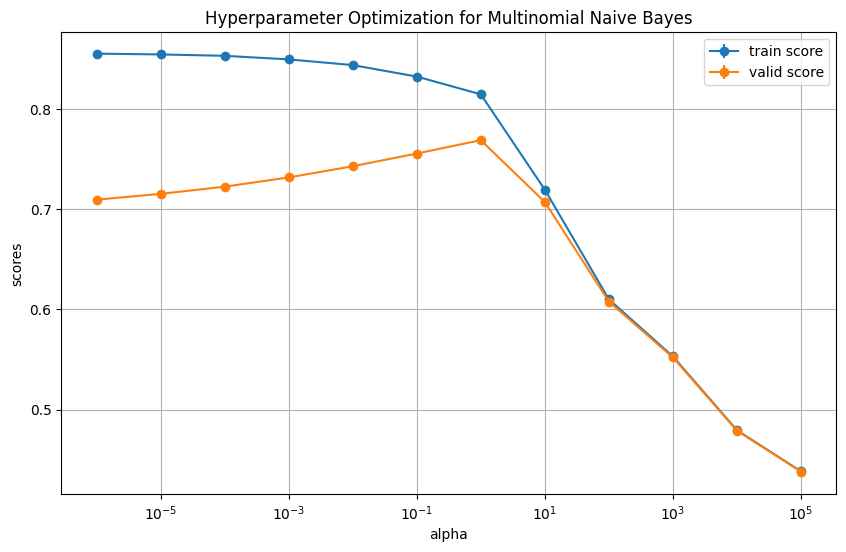

Best hyperparameters for Multinomial Naive Bayes: {'alpha': 1}
Optimized Multinomial Naive Bayes 
Test Accuracy: 0.7702339472374315


Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.60      0.59      0.59      3621
 CONCLUSIONS       0.66      0.72      0.69      4571
     METHODS       0.84      0.87      0.85      9897
   OBJECTIVE       0.59      0.54      0.56      2333
     RESULTS       0.87      0.82      0.84      9713

    accuracy                           0.77     30135
   macro avg       0.71      0.71      0.71     30135
weighted avg       0.77      0.77      0.77     30135



In [21]:
baseline_optimized_model(
    CountVectorizer(), 
    MultinomialNB(), 
    param_grid_mnb, 
    train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
    "Multinomial Naive Bayes"
)

### model - Logistic Regression (scikit-learn)
#### Performs well on vectorized text data

In [31]:
# Best hyperparameters for Logistic Regression: {'C': 0.1, 'solver': 'saga'}

In [32]:
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                 }

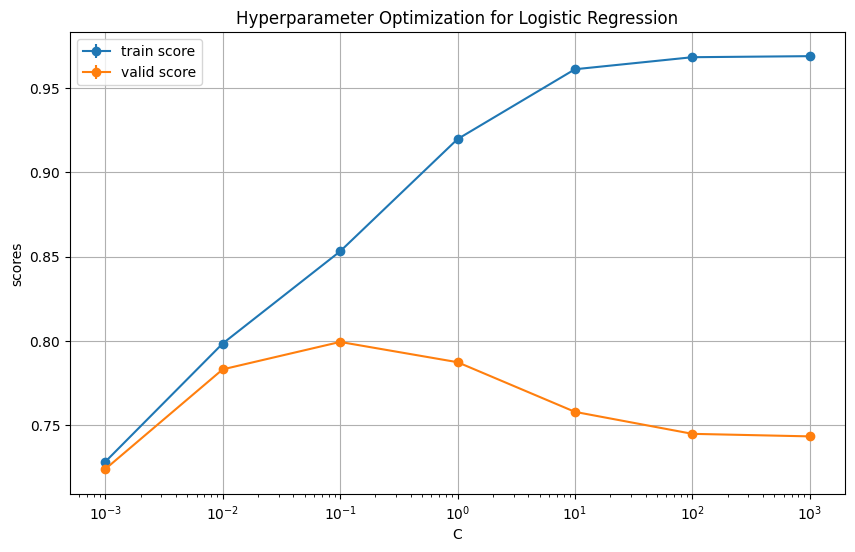

Best hyperparameters for Logistic Regression: {'C': 0.1}
Optimized Logistic Regression 
Test Accuracy: 0.8


Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.62      0.64      0.63      3621
 CONCLUSIONS       0.73      0.71      0.72      4571
     METHODS       0.85      0.91      0.88      9897
   OBJECTIVE       0.67      0.51      0.58      2333
     RESULTS       0.87      0.86      0.87      9713

    accuracy                           0.80     30135
   macro avg       0.75      0.73      0.74     30135
weighted avg       0.80      0.80      0.80     30135

Execution time : 2182.7552247047424s.


In [34]:
start = time.time()

baseline_optimized_model(
    CountVectorizer(), 
    LogisticRegression(max_iter=5000, solver='saga'), 
    param_grid_lr,
    train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
    "Logistic Regression"
)

end = time.time()
print(f"Execution time : {end - start}s.")

### model - RandomForest (scikit-learn)

In [ ]:
# Best hyperparameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}

In [27]:
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

In [28]:
start = time.time()

baseline_optimized_model(
    CountVectorizer(), 
    RandomForestClassifier(random_state=42), 
    param_grid_rf,
    train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
    "Random Forest"
)

end = time.time()
print(f"Execution time : {end - start}s.")

/home/mhayakawa/miniconda3/envs/rapids_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mhayakawa/miniconda3/envs/rapids_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mhayakawa/miniconda3/envs/rapids_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mhayakawa/miniconda3/envs/rapids_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mhayakawa/miniconda3/envs/rapids_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did 

Best hyperparameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Optimized Random Forest 
Test Accuracy: 0.7823461091753775


Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.68      0.55      0.61      3621
 CONCLUSIONS       0.72      0.62      0.66      4571
     METHODS       0.80      0.93      0.86      9897
   OBJECTIVE       0.72      0.46      0.56      2333
     RESULTS       0.83      0.87      0.85      9713

    accuracy                           0.78     30135
   macro avg       0.75      0.69      0.71     30135
weighted avg       0.78      0.78      0.77     30135

Execution time : 3570.290277004242s.


## 1.b Preprocessing : TfidfVectorizer

### model - Multinomial Naive Bayes (scikit-learn)

In [39]:
param_grid_mnb = {'alpha': [10**k  for k in range(-6,6,1)]}

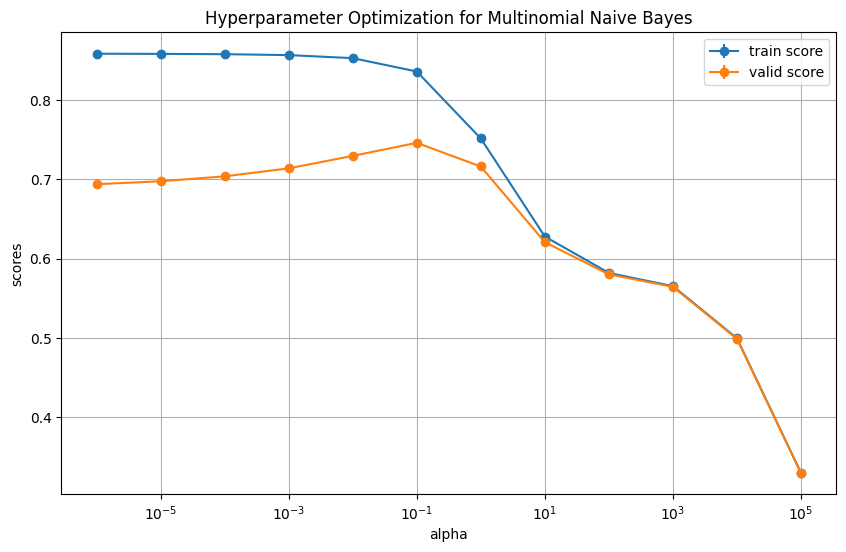

Best hyperparameters for Multinomial Naive Bayes: {'alpha': 0.1}
Optimized Multinomial Naive Bayes 
Test Accuracy: 0.7451136552181848


Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.59      0.52      0.55      3621
 CONCLUSIONS       0.63      0.65      0.64      4571
     METHODS       0.78      0.87      0.82      9897
   OBJECTIVE       0.60      0.35      0.44      2333
     RESULTS       0.82      0.84      0.83      9713

    accuracy                           0.75     30135
   macro avg       0.69      0.65      0.66     30135
weighted avg       0.74      0.75      0.74     30135



In [40]:
baseline_optimized_model(
    TfidfVectorizer(), 
    MultinomialNB(), 
    param_grid_mnb,
    train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
    "Multinomial Naive Bayes"
)

### model - Logistic Regression (scikit-learn)

In [14]:
param_grid_lr = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

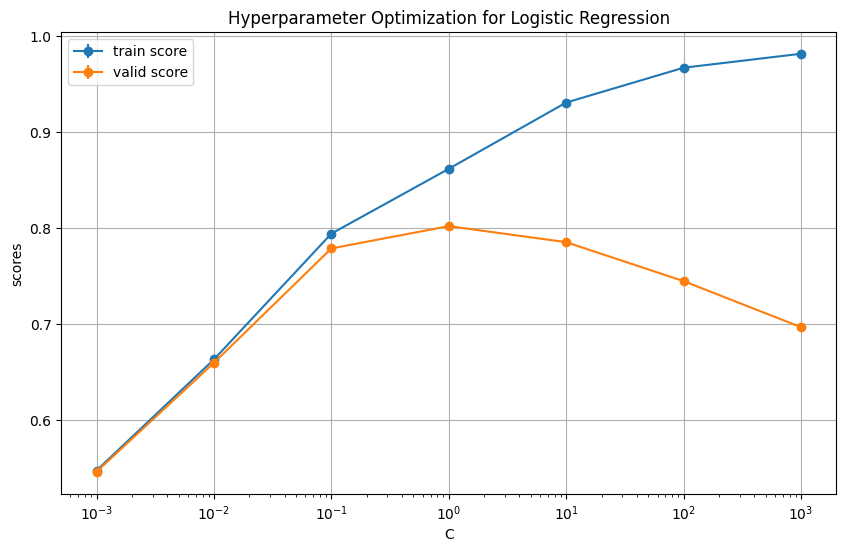

Best hyperparameters for Logistic Regression: {'C': 1}
Optimized Logistic Regression 
Test Accuracy: 0.8023560643769703


Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.63      0.63      0.63      3621
 CONCLUSIONS       0.73      0.72      0.72      4571
     METHODS       0.85      0.91      0.88      9897
   OBJECTIVE       0.67      0.52      0.58      2333
     RESULTS       0.87      0.87      0.87      9713

    accuracy                           0.80     30135
   macro avg       0.75      0.73      0.74     30135
weighted avg       0.80      0.80      0.80     30135

Execution time : 362.87997579574585s.


In [15]:
start = time.time()

baseline_optimized_model(
    TfidfVectorizer(), 
    LogisticRegression(max_iter=5000, solver='saga'), 
    param_grid_lr,
    train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
    "Logistic Regression"
)

end = time.time()
print(f"Execution time : {end - start}s.")

### model - RandomForest (scikit-learn)

In [16]:
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10]
}

In [18]:
start = time.time()

baseline_optimized_model(
    TfidfVectorizer(), 
    RandomForestClassifier(random_state=42), 
    param_grid_rf,
    train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
    "Random Forest"
)

end = time.time()
print(f"Execution time : {end - start}s.")

Best hyperparameters for Random Forest: {'max_depth': None, 'n_estimators': 100}
Optimized Random Forest 
Test Accuracy: 0.780653724904596


Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.66      0.56      0.60      3621
 CONCLUSIONS       0.71      0.62      0.66      4571
     METHODS       0.80      0.93      0.86      9897
   OBJECTIVE       0.74      0.46      0.57      2333
     RESULTS       0.83      0.87      0.85      9713

    accuracy                           0.78     30135
   macro avg       0.75      0.69      0.71     30135
weighted avg       0.77      0.78      0.77     30135

Execution time : 3784.943111896515s.


## 2. Embedding-based model: BioWordVec 

### Load BioWordVec embeddings

In [8]:
word_vectors = KeyedVectors.load_word2vec_format("BioWordVec.bin", binary=True, limit=500000) 

### Convert sentences to vectors using BioWordVec, then datasets into vector representations

In [8]:
def embed_sentences(sentences, word_vectors):
    embeddings = []
    #punct_exclude = "?.,!'#$%&()*+-/:;<=>@[\]^_`{|}~"
    for sentence in sentences:
        # Process the sentence with spaCy (DISCARDED - computationally too expensive.) 
        
        # doc = nlp(sentence)
        # tokens = [token.text for token in doc if not token.is_punct and not token.is_space]

        # Retrieve embeddings for tokens present in the word_vectors
        # words = [word.strip(punct_exclude) for word in sentence.split()]
        words = sentence.split()
        word_embeddings = [word_vectors[word] for word in words if word in word_vectors]
        
        if word_embeddings:
            embeddings.append(np.mean(word_embeddings, axis=0))
        else:
            embeddings.append(np.zeros(word_vectors.vector_size)) # Zero vector when no match
            
    return np.array(embeddings)

In [9]:
def embedding_optimized_model(classifier, param_grid, word_vectors, train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, classifier_name):
    # Convert sentences into embeddings
    X_train = embed_sentences(train_sentences, word_vectors)
    X_val   = embed_sentences(val_sentences, word_vectors)
    X_test  = embed_sentences(test_sentences, word_vectors)

    # Check if the classifier is XGBoost, encode labels accordingly
    if isinstance(classifier, XGBClassifier):
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(train_labels)
        y_val   = label_encoder.transform(val_labels)
        y_test  = label_encoder.transform(test_labels)
    else:
        y_train = np.array(train_labels)
        y_val   = np.array(val_labels)
        y_test  = np.array(test_labels)

    # Grid Search for Hyperparameter Tuning
    grid_search = GridSearchCV(estimator=classifier, 
                               param_grid=param_grid, 
                               cv=2, 
                               scoring='accuracy', 
                               n_jobs=-1, 
                               return_train_score=True)
    grid_search.fit(X_train, y_train)

    # Get results
    results = grid_search.cv_results_
    param_names = list(param_grid.keys())

    # Plot Test/Validation scores
    if len(param_names) == 1:
        param_values = param_grid[param_names[0]]
        mean_train_scores = results['mean_train_score']
        std_train_scores = results['std_train_score']
        mean_test_scores = results['mean_test_score']
        std_test_scores = results['std_test_score']

        plt.figure(figsize=(10, 6))
        plt.errorbar(param_values, mean_train_scores, yerr=std_train_scores, label="Train Score", marker='o')
        plt.errorbar(param_values, mean_test_scores, yerr=std_test_scores, label="Validation Score", marker='o')
        plt.xlabel(param_names[0])
        plt.ylabel("Accuracy")
        plt.xscale('log')  # Logarithmic scale
        plt.title(f"Hyperparameter Optimization for {classifier_name}")
        plt.grid(True)
        plt.legend()
        plt.show()

    best_model = grid_search.best_estimator_
    print(f"Best hyperparameters for {classifier_name}: {grid_search.best_params_}")

    # Fit the best model on the training set, then evaluate on test set
    best_model.fit(X_train, y_train)
    predictions = best_model.predict(X_test)
    print(f"\nEmbeddings + {classifier_name}\nTest Accuracy:", accuracy_score(y_test, predictions))
    print(f"\nClassification Report:\n", classification_report(y_test, predictions))

### MultinomialNB NOT suitable anymore because it assumes count-based data (like Bag-of-Words or TF-IDF), while word embeddings provide real-valued vectors

### model - Logistic Regression
Works well with continuous features like word embeddings.

Computationally efficient and scalable.

Should be great for fast experimentation with BioWordVec.

In [13]:
param_grid_lr = {'C': [10**k  for k in range(-1,3,1)]}

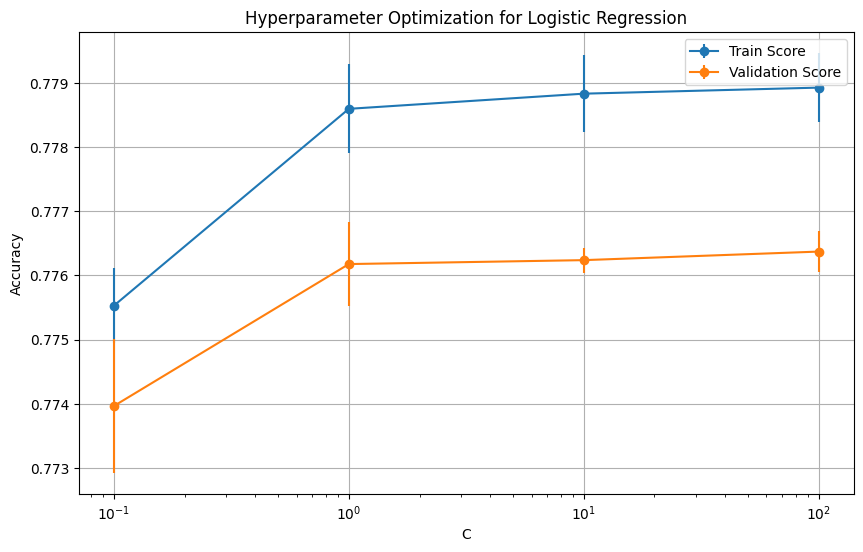

Best hyperparameters for Logistic Regression: {'C': 100}

Embeddings + Logistic Regression
Test Accuracy: 0.7704662352745977

Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.60      0.56      0.58      3621
 CONCLUSIONS       0.67      0.68      0.68      4571
     METHODS       0.82      0.88      0.85      9897
   OBJECTIVE       0.62      0.52      0.56      2333
     RESULTS       0.86      0.84      0.85      9713

    accuracy                           0.77     30135
   macro avg       0.71      0.70      0.70     30135
weighted avg       0.77      0.77      0.77     30135

Execution time : 582.1450176239014s.


In [18]:
start = time.time()

embedding_optimized_model(LogisticRegression(max_iter=5000), 
                          param_grid_lr,
                          word_vectors, 
                          train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
                          "Logistic Regression")

end = time.time()
print(f"Execution time : {end - start}s.")

### model - LinearSVC  
#### tried on SVM but took 3h30 to NOT get results, thus changed to LinearSVC to get O(n^2) -> O(n) complexity diff.

In [16]:
param_grid_svm = {'C': [10**k  for k in range(-1,4,1)]}

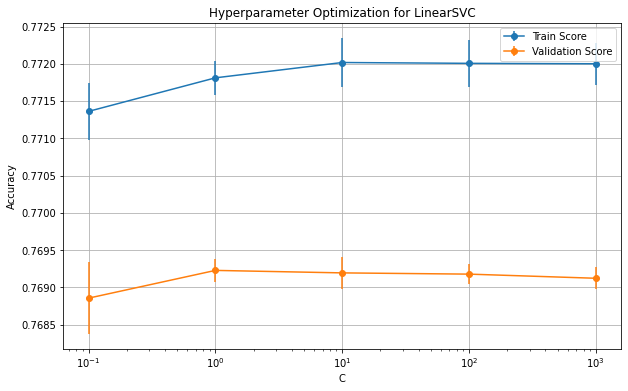

Best hyperparameters for LinearSVC: {'C': 1}

Embeddings + LinearSVC
Test Accuracy: 0.7667828106852497

Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.64      0.52      0.57      3621
 CONCLUSIONS       0.67      0.67      0.67      4571
     METHODS       0.79      0.89      0.84      9897
   OBJECTIVE       0.63      0.49      0.55      2333
     RESULTS       0.85      0.84      0.85      9713

    accuracy                           0.77     30135
   macro avg       0.72      0.68      0.70     30135
weighted avg       0.76      0.77      0.76     30135

Execution time : 267.53201961517334s.


In [17]:
start = time.time()

embedding_optimized_model(LinearSVC(max_iter=5000), 
                          param_grid_svm, 
                          word_vectors, 
                          train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
                          "LinearSVC")

end = time.time()
print(f"Execution time : {end - start}s.")

## 3. Deep learning based model : CNN

In [35]:
max_vocab_size = len(vocabulary) 
max_sequence_length = 47  # average sentence length

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)

# sentences -> sequences of indices
X_train_seq = tokenizer.texts_to_sequences(train_sentences)
X_val_seq = tokenizer.texts_to_sequences(val_sentences)
X_test_seq = tokenizer.texts_to_sequences(test_sentences)

# Pad sequences to ensure uniform input size
X_train = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_val = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

# encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_val = label_encoder.transform(val_labels)
y_test = label_encoder.transform(test_labels)

# one-hot encoding
num_classes = len(set(train_labels))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# CNN architecture
cnn_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128)
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)

print(f"\nCNN Test Accuracy: {test_acc}")

2025-02-17 04:02:57.666212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-17 04:02:57.669473: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/10
1407/1407 [==============================] - 230s 163ms/step - loss: 0.6813 - accuracy: 0.7448 - val_loss: 0.4953 - val_accuracy: 0.8185
Epoch 2/10
1407/1407 [==============================] - 236s 168ms/step - loss: 0.4759 - accuracy: 0.8297 - val_loss: 0.4823 - val_accuracy: 0.8224
Epoch 3/10
1407/1407 [==============================] - 252s 179ms/step - loss: 0.3890 - accuracy: 0.8594 - val_loss: 0.4944 - val_accuracy: 0.8233
Epoch 4/10
1407/1407 [==============================] - 246s 174ms/step - loss: 0.3235 - accuracy: 0.8821 - val_loss: 0.5385 - val_accuracy: 0.8170
Epoch 5/10
1407/1407 [==============================] - 228s 162ms/step - loss: 0.2773 - accuracy: 0.8987 - val_loss: 0.5719 - val_accuracy: 0.8126
Epoch 6/10
1407/1407 [==============================] - 238s 169ms/step - loss: 0.2419 - accuracy: 0.9125 - val_loss: 0.6279 - val_accuracy: 0.8073
Epoch 7/10
1407/1407 [==============================] - 246s 175ms/step - loss: 0.2123 - accuracy: 0.9238 - val_

942/942 [==============================] - 4s 4ms/step


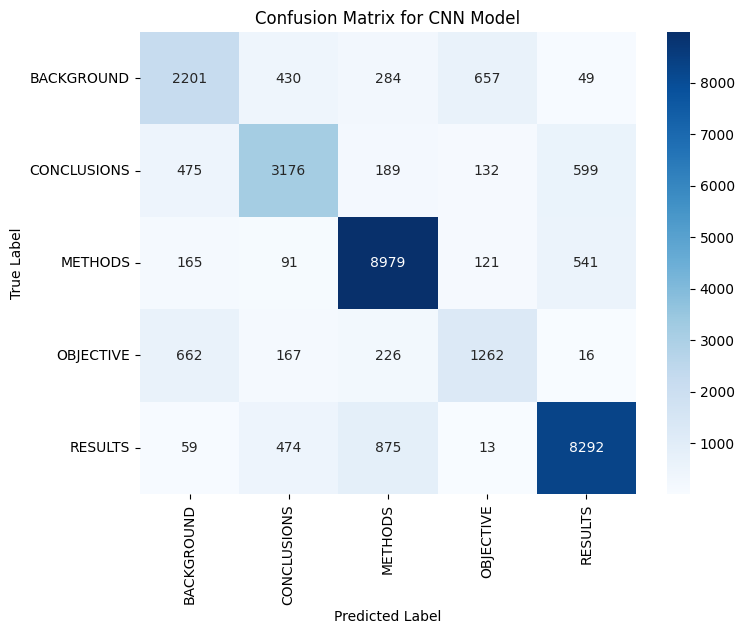

In [42]:
# Predictions 
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class indices
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class indices

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for CNN Model')
plt.show()

# [DEPLOYMENT]

## Train with the best hyperparameter found during Experimentation (cf. GridSearchCV) 

### While it isn't the most pertinent approach there could be (to base our conclusion on results on a dataset representing 10% of the actual dataset), it was computationally too expensive for my computer to keep up (time & RAM) with fine-tuning on the 200k dataset.  

## 1. Baseline model: Bag-of-Words 

In [9]:
def baseline_vec_model(vectorizer, model, train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, classifier_name):
# Vectorize input sentences
    X_train = vectorizer.fit_transform(train_sentences) if vectorizer else train_sentences
    X_test = vectorizer.transform(test_sentences) if vectorizer else test_sentences

    # Fit the best model
    model.fit(X_train, train_labels)
    predictions = model.predict(X_test)

    # Evaluate the model
    print(f"Optimized {classifier_name} \nTest Accuracy:", accuracy_score(test_labels, predictions))
    print(f"\n\nClassification Report:\n", classification_report(test_labels, predictions))

    # Generate and display the confusion matrix
    cm = confusion_matrix(test_labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(test_labels), yticklabels=set(test_labels))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {classifier_name}")
    plt.show()

## 1.a Preprocessing : CountVectorizer

Optimized Multinomial Naive Bayes 
Test Accuracy: 0.7840843590004408


Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.58      0.57      0.58      2663
 CONCLUSIONS       0.68      0.74      0.71      4426
     METHODS       0.85      0.86      0.86      9751
   OBJECTIVE       0.62      0.64      0.63      2377
     RESULTS       0.87      0.82      0.84     10276

    accuracy                           0.78     29493
   macro avg       0.72      0.73      0.72     29493
weighted avg       0.79      0.78      0.79     29493


Confusion Matrix:
 [[1530  421  146  523   43]
 [ 426 3289  110  142  459]
 [ 155  241 8375  238  742]
 [ 458  201  178 1528   12]
 [  77  720 1029   47 8403]]


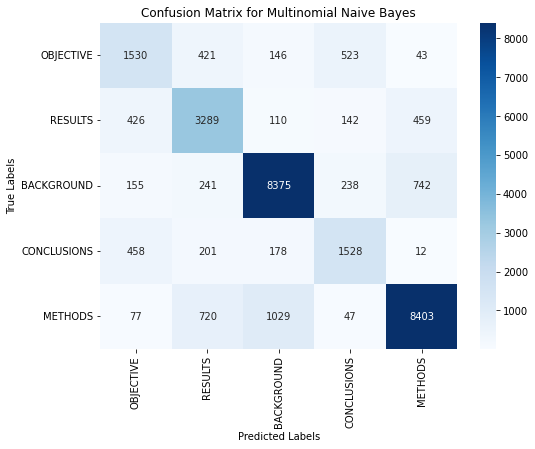

In [14]:
baseline_vec_model(
    CountVectorizer(), 
    MultinomialNB(alpha=1), 
    train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
    "Multinomial Naive Bayes"
)

Optimized Logistic Regression 
Test Accuracy: 0.827247143389957


Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.64      0.61      0.62      2663
 CONCLUSIONS       0.78      0.75      0.76      4426
     METHODS       0.86      0.92      0.89      9751
   OBJECTIVE       0.72      0.61      0.66      2377
     RESULTS       0.88      0.88      0.88     10276

    accuracy                           0.83     29493
   macro avg       0.78      0.75      0.76     29493
weighted avg       0.82      0.83      0.82     29493


Confusion Matrix:
 [[1619  372  234  400   38]
 [ 302 3321  126   61  616]
 [  61   93 8947   78  572]
 [ 523  174  203 1456   21]
 [  36  319  852   14 9055]]


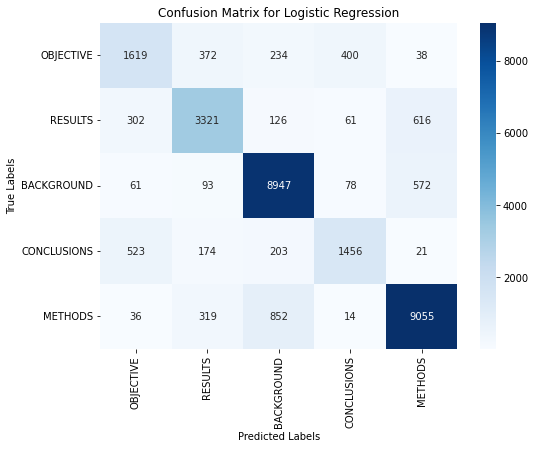

In [16]:
baseline_vec_model(
    CountVectorizer(), 
    LogisticRegression(C=0.1, solver='saga', max_iter=5000),
    train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
    "Logistic Regression"
)

Optimized Random Forest 
Test Accuracy: 0.5834943884989658


Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       1.00      0.00      0.00      2663
 CONCLUSIONS       0.80      0.02      0.05      4426
     METHODS       0.60      0.84      0.70      9751
   OBJECTIVE       0.33      0.00      0.00      2377
     RESULTS       0.57      0.87      0.69     10276

    accuracy                           0.58     29493
   macro avg       0.66      0.35      0.29     29493
weighted avg       0.63      0.58      0.48     29493



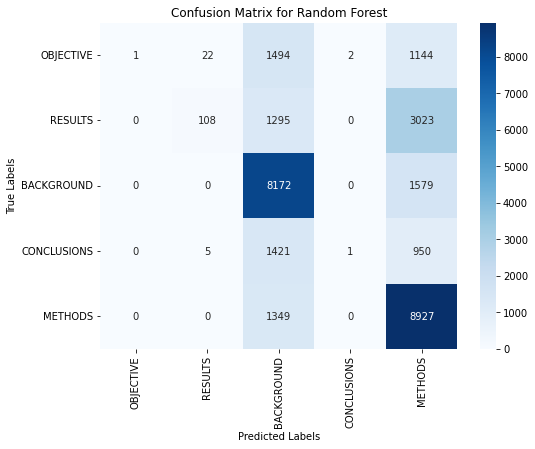

In [31]:
baseline_vec_model(
    CountVectorizer(), 
    RandomForestClassifier(min_samples_split=5, n_estimators=50, max_depth=20, random_state=42, n_jobs=-1),
    train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
    "Random Forest"
)

## 1.b Preprocessing : TfidfVectorizer

Optimized Multinomial Naive Bayes 
Test Accuracy: 0.7713694775031363


Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.62      0.46      0.53      2663
 CONCLUSIONS       0.67      0.71      0.69      4426
     METHODS       0.81      0.86      0.84      9751
   OBJECTIVE       0.68      0.49      0.57      2377
     RESULTS       0.82      0.86      0.84     10276

    accuracy                           0.77     29493
   macro avg       0.72      0.67      0.69     29493
weighted avg       0.76      0.77      0.77     29493



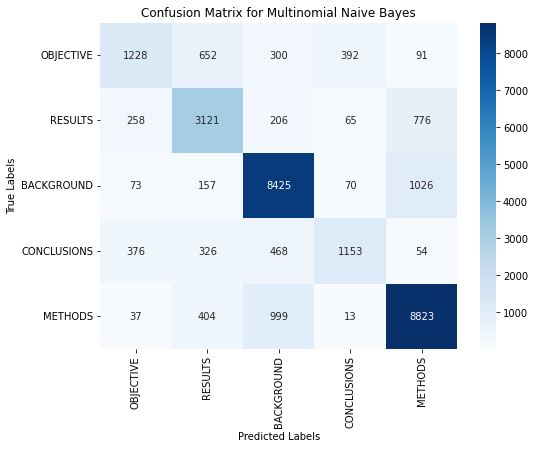

In [32]:
baseline_vec_model(
    TfidfVectorizer(), 
    MultinomialNB(alpha=0.1), 
    train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
    "Multinomial Naive Bayes"
)

Optimized Logistic Regression 
Test Accuracy: 0.8231444749601601


Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.65      0.58      0.61      2663
 CONCLUSIONS       0.76      0.75      0.75      4426
     METHODS       0.86      0.92      0.89      9751
   OBJECTIVE       0.72      0.61      0.66      2377
     RESULTS       0.87      0.88      0.88     10276

    accuracy                           0.82     29493
   macro avg       0.77      0.75      0.76     29493
weighted avg       0.82      0.82      0.82     29493



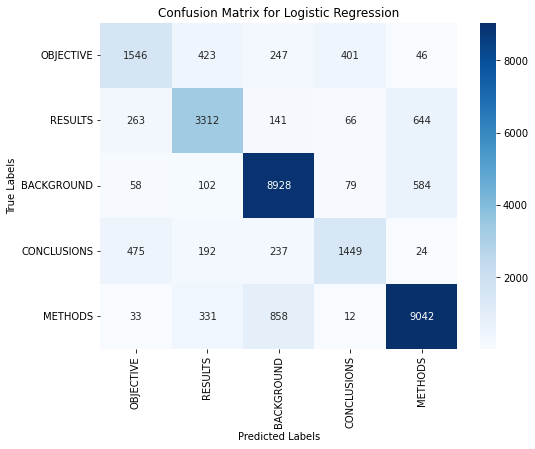

In [33]:
baseline_vec_model(
    TfidfVectorizer(), 
    LogisticRegression(C=0.1, solver='saga', max_iter=5000),
    train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
    "Logistic Regression"
)

Optimized Random Forest 
Test Accuracy: 0.5890211236564609


Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.00      0.00      0.00      2663
 CONCLUSIONS       0.80      0.04      0.07      4426
     METHODS       0.60      0.85      0.70      9751
   OBJECTIVE       1.00      0.00      0.00      2377
     RESULTS       0.58      0.87      0.70     10276

    accuracy                           0.59     29493
   macro avg       0.60      0.35      0.29     29493
weighted avg       0.60      0.59      0.48     29493



/home/mhayakawa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhayakawa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mhayakawa/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


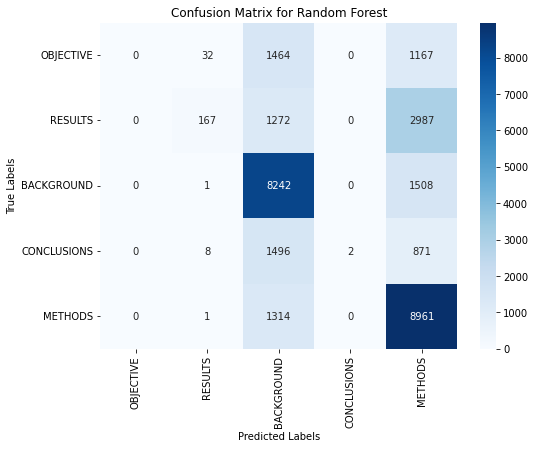

In [35]:
baseline_vec_model(
    TfidfVectorizer(), 
    RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42, n_jobs=-1),
    train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
    "Random Forest"
)

## 2. Embedding-based model: BioWordVec 

### Load BioWordVec embeddings

In [10]:
word_vectors = KeyedVectors.load_word2vec_format("BioWordVec.bin", binary=True, limit=500000) 

In [11]:
def embed_sentences(sentences, word_vectors):
    """
    Convert sentences into their average word embeddings.
    """
    embeddings = []
    for sentence in sentences:
        words = sentence.split()
        word_embeddings = [word_vectors[word] for word in words if word in word_vectors]
    
        if word_embeddings:
            embeddings.append(np.mean(word_embeddings, axis=0))
        else:
            embeddings.append(np.zeros(word_vectors.vector_size)) # Zero vector when no match
            
    return np.array(embeddings)

In [12]:
def embedding_optimized_model(model, word_vectors, train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, classifier_name):
    # Convert sentences into embeddings
    X_train = embed_sentences(train_sentences, word_vectors)
    X_val   = embed_sentences(val_sentences, word_vectors)
    X_test  = embed_sentences(test_sentences, word_vectors)

    # Check if the classifier is XGBoost, encode labels accordingly
    if isinstance(model, XGBClassifier):
        label_encoder = LabelEncoder()
        y_train = label_encoder.fit_transform(train_labels)
        y_val   = label_encoder.transform(val_labels)
        y_test  = label_encoder.transform(test_labels)
    else:
        y_train = np.array(train_labels)
        y_val   = np.array(val_labels)
        y_test  = np.array(test_labels)

    # Fit the best model on the training set, then evaluate on test set
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print(f"\nEmbeddings + {classifier_name}\nTest Accuracy:", accuracy_score(y_test, predictions))
    print(f"\nClassification Report:\n", classification_report(y_test, predictions))

    # Generate and display the confusion matrix
    cm = confusion_matrix(test_labels, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(test_labels), yticklabels=set(test_labels))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix for {classifier_name}")
    plt.show()


Embeddings + Logistic Regression
Test Accuracy: 0.7873393686637508

Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.60      0.47      0.52      2663
 CONCLUSIONS       0.69      0.72      0.70      4426
     METHODS       0.83      0.88      0.86      9751
   OBJECTIVE       0.65      0.62      0.63      2377
     RESULTS       0.86      0.85      0.85     10276

    accuracy                           0.79     29493
   macro avg       0.73      0.71      0.71     29493
weighted avg       0.78      0.79      0.78     29493



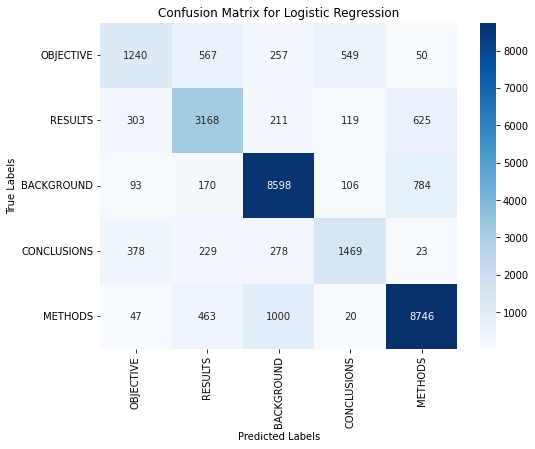

In [41]:
embedding_optimized_model(LogisticRegression(C=100, max_iter=5000), 
                          word_vectors, 
                          train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
                          "Logistic Regression")


Embeddings + LinearSVC
Test Accuracy: 0.7813040382463635

Classification Report:
               precision    recall  f1-score   support

  BACKGROUND       0.64      0.41      0.50      2663
 CONCLUSIONS       0.69      0.70      0.69      4426
     METHODS       0.80      0.89      0.85      9751
   OBJECTIVE       0.67      0.59      0.62      2377
     RESULTS       0.84      0.86      0.85     10276

    accuracy                           0.78     29493
   macro avg       0.73      0.69      0.70     29493
weighted avg       0.77      0.78      0.77     29493



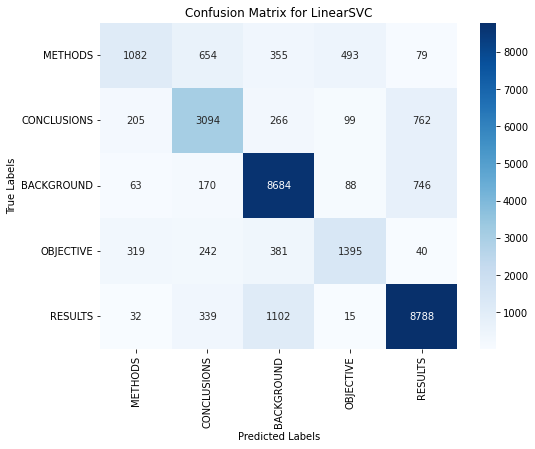

In [13]:
embedding_optimized_model(LinearSVC(C=1, max_iter=5000), 
                          word_vectors, 
                          train_sentences, train_labels, val_sentences, val_labels, test_sentences, test_labels, 
                          "LinearSVC")

## 3. Deep Learning Based Model : CNN

In [ ]:
max_vocab_size = len(vocabulary) 
max_sequence_length = 47  # average sentence length

# Tokenize the dataset
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)

# Convert sentences into sequences of indices
X_train_seq = tokenizer.texts_to_sequences(train_sentences)
X_val_seq = tokenizer.texts_to_sequences(val_sentences)
X_test_seq = tokenizer.texts_to_sequences(test_sentences)

# Pad sequences to ensure uniform input size
X_train = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_val = pad_sequences(X_val_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

# encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_val = label_encoder.transform(val_labels)
y_test = label_encoder.transform(test_labels)

# one-hot encoding
num_classes = len(set(train_labels))
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# CNN architecture
cnn_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the CNN
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128)
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)

print(f"\nCNN Test Accuracy: {test_acc}")

In [ ]:
# Predictions 
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert one-hot to class indices
y_true_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class indices

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for CNN Model')
plt.show()

## 4. Deep Learning Based Model: Transformer (BERT)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Optional models you can choose from (pick one)
model_checkpoint = "distilbert-base-uncased"  # Small & fast
# model_checkpoint = "bert-base-uncased"      # Bigger BERT
# model_checkpoint = "roberta-base"           # RoBERTa model

# Step 1: Encode labels if they're strings
label_encoder = LabelEncoder()
train_labels_enc = label_encoder.fit_transform(train_labels)
val_labels_enc = label_encoder.transform(val_labels)
test_labels_enc = label_encoder.transform(test_labels)

# Step 2: Tokenize the text data
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Step 3: Create datasets for Hugging Face
train_dataset = Dataset.from_dict({"text": train_sentences, "label": train_labels_enc})
val_dataset = Dataset.from_dict({"text": val_sentences, "label": val_labels_enc})
test_dataset = Dataset.from_dict({"text": test_sentences, "label": test_labels_enc})

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Step 4: Load the model for classification (2 or more labels)
num_labels = len(label_encoder.classes_)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

# Step 5: Define metrics for evaluation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Step 6: Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Step 7: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Step 8: Train the model
trainer.train()

# Step 9: Evaluate on test set
trainer.evaluate(test_dataset)

Map:   0%|          | 0/2211861 [00:02<?, ? examples/s]